# **Data Preprocessing: Stage Two**

1. Imbalance Training W/ Mel alone - 80/20 training
-	Get the durations for all the species
-	Do a 80-20 train-val intraspecies split 
- Windowed Mels just doing it how I used to do it without the start and end time information
- I'll do 2 seconds, 4 seconds, and 6 seconds with half overlap
- I will add some features to help the model learn
- Just comparing how it is with new features
- Normalization too for the audio and the spectrograms
- 200 px x 300 px
- Just comparing how it is with raw audio data to spectrograms
- Will do average pooled with filter, average pooled without filter, normal with filter, normal without filter


In [46]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# for normalization & avgpooling features
from sklearn.preprocessing import MinMaxScaler # to squeeze all the features to be within 0 and 1
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
from playsound import playsound
import pygame
import time
from scipy.signal import butter, filtfilt
import random
import IPython.display as ipd

In [12]:
def play_sound(file_path):
    """
    Plays the sound file specified by file_path.

    Parameters:
        file_path (str): The path to the sound file to be played.
    """
    try:
        pygame.mixer.init()
        pygame.mixer.music.load(file_path)
        pygame.mixer.music.play()
        
        # Keep the program running while the sound is playing
        while pygame.mixer.music.get_busy():
            time.sleep(1)

    except Exception as e:
        print(f"An error occurred: {e}")

In [14]:
play_sound('sound.wav')

In [16]:
# Variabels to be reused
path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/audio_files' 
npy_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train_audio_npy/' 
train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train.csv' 
annotated_train_csv = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/train-annotated.csv'
sr = 22050

In [17]:
df_train = pd.read_csv(train_csv) # Reading in training data
df_train.head()

,Unnamed: 0,species,audio_name,duration,filename_npy
0,740,Motacilla flava,XC252756.mp3,78.216009,Motacilla flava/XC252756.npy
1,247,Ardea purpurea,XC467373.mp3,19.578050,Ardea purpurea/XC467373.npy
2,77,Acrocephalus melanopogon,XC516174.mp3,107.075918,Acrocephalus melanopogon/XC516174.npy
3,574,Gallinula chloropus,XC467260.mp3,29.753469,Gallinula chloropus/XC467260.npy
4,75,Acrocephalus melanopogon,XC467403.mp3,74.143311,Acrocephalus melanopogon/XC467403.npy


In [18]:
df_train['species'].value_counts()

species
Himantopus himantopus        48
Tachybaptus ruficollis       43
Charadrius alexandrinus      42
Alcedo atthis                42
Botaurus stellaris           42
Fulica atra                  40
Gallinula chloropus          40
Acrocephalus melanopogon     33
Porphyrio porphyrio          33
Ardea purpurea               31
Motacilla flava              30
Dendrocopos minor            28
Acrocephalus arundinaceus    28
Ixobrychus minutus           27
Acrocephalus scirpaceus      27
Ciconia ciconia              24
Circus aeruginosus           23
Coracias garrulus            16
Anas platyrhynchos           11
Anas strepera                 7
Name: count, dtype: int64

In [19]:
filepaths = df_train['filename_npy']
filepaths

0               Motacilla flava/XC252756.npy
1                Ardea purpurea/XC467373.npy
2      Acrocephalus melanopogon/XC516174.npy
3           Gallinula chloropus/XC467260.npy
4      Acrocephalus melanopogon/XC467403.npy
                       ...                  
610                 Fulica atra/XC550266.npy
611              Ciconia ciconia/XC25468.npy
612           Dendrocopos minor/XC519985.npy
613                 Fulica atra/XC480979.npy
614             Motacilla flava/XC469959.npy
Name: filename_npy, Length: 615, dtype: object

## Get the durations for all the species

In [20]:
duration_sum = df_train.groupby('species', as_index=False)['duration'].sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('duration', ascending=False)
duration_sum.head(20)

,species,duration,duration_mins
0,Acrocephalus arundinaceus,4229.187755,70.486463
2,Acrocephalus scirpaceus,3365.564263,56.092738
12,Dendrocopos minor,2515.564490,41.926075
1,Acrocephalus melanopogon,2219.113605,36.985227
7,Botaurus stellaris,1900.025896,31.667098
15,Himantopus himantopus,1792.343764,29.872396
17,Motacilla flava,1577.604989,26.293416
19,Tachybaptus ruficollis,1520.178277,25.336305
16,Ixobrychus minutus,1307.966893,21.799448
11,Coracias garrulus,1249.297370,20.821623


### Do a 80-20 training and validation split for each species so enough intraspecies sample variation

In [21]:
shuffled_train = df_train.sample(frac=1, random_state=6969) # shuffle the original df before splitting to train/val

In [22]:
def intraspecies_split(df, split_ratio=0.8):
    train_data = pd.DataFrame() 
    val_data = pd.DataFrame()    
    
    # Group by 'species' and split within each species
    for species in df['species'].unique():
        species_df = df[df['species'] == species].copy()
        
        species_df = species_df.sample(frac=1, random_state=6969).reset_index(drop=True)
        train, val = train_test_split(species_df, train_size=split_ratio, random_state=69)
        
        # Concatenate the result back into the main train and validation dataframes
        train_data = pd.concat([train_data, train])
        val_data = pd.concat([val_data, val])
    
    # Reset the index of the final dataframes
    train_data = train_data.reset_index(drop=True)
    val_data = val_data.reset_index(drop=True)
    
    return train_data, val_data

In [23]:
# Doing the intraspecies split
train_df, val_df = intraspecies_split(shuffled_train)

In [24]:
# Check the results
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 483
Validation set size: 132


### Confirm no duplicates and the samples in validation set are not in the training set

In [25]:
assert len(val_df) == val_df['filename_npy'].nunique()

In [26]:
assert len(train_df) == train_df['filename_npy'].nunique()

In [27]:
is_present = val_df['filename_npy'].isin(train_df['filename_npy']).any()

assert not is_present, "Validation set contains samples from training set!"

### Combining the training and validation sets into one set with a column identifying the set the samples belong to

In [28]:
train_df['set'] = 'tr'
val_df['set'] = 'val'

merged_train = pd.concat([train_df, val_df])

In [30]:
duration_sum = merged_train[['species', 'duration', 'set']].groupby(['species', 'set'], as_index=False).sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('species', ascending=False)
duration_sum.head(20)


,species,set,duration,duration_mins
39,Tachybaptus ruficollis,val,421.328798,7.022147
38,Tachybaptus ruficollis,tr,1098.849478,18.314158
37,Porphyrio porphyrio,val,59.189206,0.986487
36,Porphyrio porphyrio,tr,1182.791383,19.713190
35,Motacilla flava,val,394.552472,6.575875
34,Motacilla flava,tr,1183.052517,19.717542
33,Ixobrychus minutus,val,292.606531,4.876776
32,Ixobrychus minutus,tr,1015.360363,16.922673
30,Himantopus himantopus,tr,1441.278912,24.021315
31,Himantopus himantopus,val,351.064853,5.851081


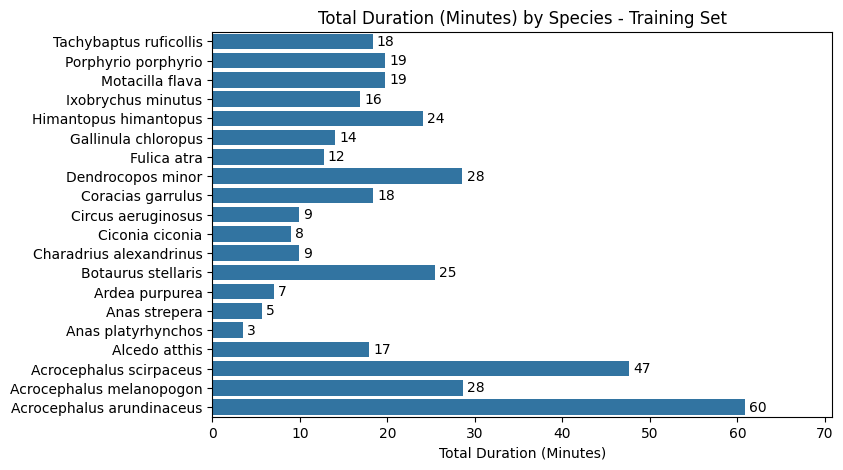

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='tr'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='tr']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

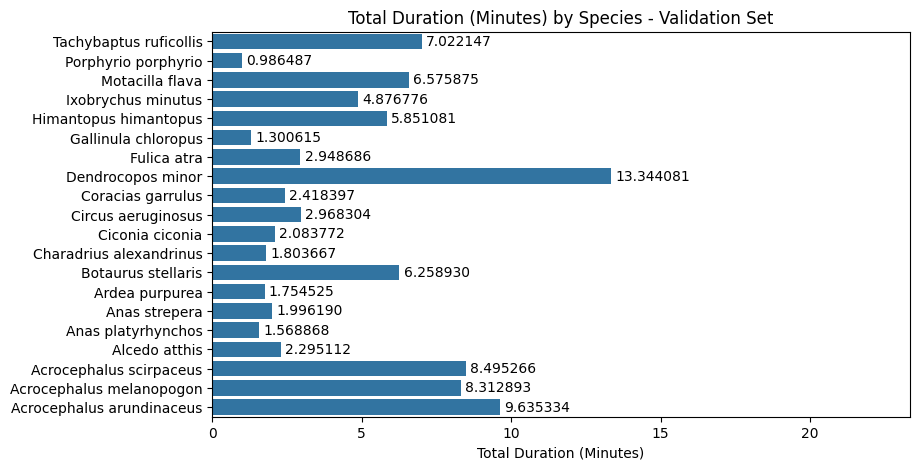

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,5))

sns.barplot(x='duration_mins', y='species', data=duration_sum[duration_sum['set'] =='val'], ax=axes)
axes.bar_label(axes.containers[0], fmt='%f', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

In [34]:
merged_train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/trainval-split/stage-2-1-trainval.csv', index=False)

# Feature Extraction

Turning the data into Mel-spectrograms 

In [40]:
save_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/'  # Where to save Mel spectrograms
n_mels = 128
target_shape = (200,300)
sr = 22050

In [36]:
# Loading the train-validation split CSV
csv_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/trainval-split/stage-2-1-trainval.csv'
trainval_data = pd.read_csv(csv_path)
train_data = trainval_data[trainval_data['set'] == 'tr']
val_data = trainval_data[trainval_data['set'] == 'val']

In [42]:
# Function to normalize audio data between 0 and 1
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))


In [41]:
def bandpass_filter(audio, lowcut=500, highcut=8000, sr=sr, order=4):
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter to audio
    filtered_audio = filtfilt(b, a, audio)
    return filtered_audio

In [43]:
def generate_pink_noise(num_samples):
    white_noise = np.random.randn(num_samples)
    
    # Apply a filter to convert white noise into pink noise (1/f noise)
    X = np.fft.rfft(white_noise)
    S = np.arange(1, len(X) + 1)  # Frequency scaling
    pink_noise = np.fft.irfft(X / S)
    
    return normalize_audio(pink_noise)

In [44]:
def avg_pooling_keras(mel_spectrograms):
    """
    Apply average pooling to mel spectrograms using Keras.

    Parameters:
      mel_spectrograms (np.array): Input features of shape (num_samples, n_mels, time_steps)

    Returns:
      np.array: Pooled features of shape (num_samples, n_mels)
    """
    # Clear the previous Keras session
    tf.keras.backend.clear_session()

    # Define the input shape based on features
    input_shape = mel_spectrograms.shape[1:]  # (n_mels, time_steps)

    # Create the Keras model for average pooling
    inputs = tf.keras.layers.Input(shape=input_shape)
    pooled = tf.keras.layers.GlobalAveragePooling1D()(inputs)
    pooling_model = tf.keras.models.Model(inputs=inputs, outputs=pooled)

    # Perform pooling using the model
    pooled_features = pooling_model.predict(mel_spectrograms)

    return pooled_features

In [61]:
def pad_with_noise(audio_data, window_length, sr=sr):
    current_length = librosa.get_duration(y=audio_data, sr=sr)
    if current_length >= window_length:
        return audio_data
    
    target_length_samples = int(window_length * sr) + 1
    current_length_samples = len(audio_data)
    padding_length_samples = target_length_samples - current_length_samples
    
    # Generate pink noise to pad with
    pink_noise = generate_pink_noise(padding_length_samples)
    padded_audio = np.concatenate([audio_data, pink_noise])
    
    return padded_audio

In [59]:
def check_process_audio_file(file_path, label, sr=22050, window_size=6, overlap=0.5, target_shape=(300, 200), normalize=True, average_pooling=False, filter=True):
    audio = np.load(file_path)
    audio = normalize_audio(audio)
    audio = pad_with_noise(audio, window_length=window_size)
    if filter:
            audio = bandpass_filter(audio)

    window_samples = int(window_size * sr)
    hop_samples = int(window_samples * (1 - overlap))  # For overlapping

    # Break the audio into windows with the specified overlap
    audio_windows = librosa.util.frame(audio, frame_length=window_samples, hop_length=hop_samples).T

    features = []

    for idx, window in enumerate(audio_windows):
        # Handle padding for the last window if necessary

        if len(window) < window_samples:
            window = pad_with_noise(window, window_length=window_size)

        # Mel Spectrogram --------------------------------------------------------------------
        mel_spectrogram = librosa.feature.melspectrogram(y=window, sr=sr, n_mels=target_shape[0])
        if normalize:
            mel_spectrogram = librosa.util.normalize(mel_spectrogram)

        zoom_factors = (target_shape[0] / mel_spectrogram.shape[0], target_shape[1] / mel_spectrogram.shape[1])
        mel_spectrogram_resized = scipy.ndimage.zoom(mel_spectrogram, zoom_factors, order=1) 


        # Chroma feature ----------------------------------------------------------
        chroma = librosa.feature.chroma_stft(y=window, sr=sr, n_chroma=12)
        if normalize:
            chroma = librosa.util.normalize(chroma)
        
        # Resize the chroma feature to fit target shape
        chroma_resized = scipy.ndimage.zoom(chroma, (target_shape[0] / chroma.shape[0], target_shape[1] / chroma.shape[1]), order=1)
        
        # MFCC feature ------------------------------------------------------------
        mfcc = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)
        if normalize:
            mfcc = librosa.util.normalize(mfcc)

        # Resize the MFCC feature to fit the target shape
        mfcc_resized = scipy.ndimage.zoom(mfcc, (target_shape[0] / mfcc.shape[0], target_shape[1] / mfcc.shape[1]), order=1)

        # Stack the features together for this window
        combined_features = np.stack([mel_spectrogram_resized, chroma_resized, mfcc_resized], axis=-1)

        features.append(combined_features)

    features = np.array(features)

    # Apply average pooling if requested
    if average_pooling:
        pooled_features = avg_pooling_keras(features)
        return {'features': pooled_features, 'label': label}

    # If not using average pooling, return resized features
    return {'features': features, 'label': label}

In [50]:
def process_dataset(df, sr=22050, window_size=6, overlap=0.5, target_shape=(300, 200), normalize=True, average_pooling=False, save_path=''):
    processed_data = []

    # Loop over each audio file in the dataframe
    for index, row in tqdm(df.iterrows(), desc="Processing data"):
        file_path = row['filename_npy']
        label = row['species'] 
        
        # Process each audio file and add to the list
        audio_data = check_process_audio_file(
            npy_path + file_path, 
            label, 
            sr=sr, 
            window_size=window_size, 
            overlap=overlap, 
            target_shape=target_shape, 
            normalize=normalize, 
            average_pooling=average_pooling
        )
        processed_data.append(audio_data)

    # Add a new column to the dataframe with the processed spectrogram data
    df['processed_features'] = processed_data

    # Return the updated dataframe
    return df

# **Plotting Before Processing All**

In [57]:
def plot_spectrogram(spectrogram_data, window_index, window_size, file_path, sr=22050):
    if window_index < 0 or window_index >= len(spectrogram_data['features']):
        raise IndexError("Invalid window index. Please choose a valid index.")
    
    # Extracting the combined features for the selected window (Mel spectrogram, Chroma, MFCC)
    selected_features = spectrogram_data['features'][window_index]
    
    mel_spectrogram = selected_features[:, :, 0]  # Mel spectrogram
    chroma = selected_features[:, :, 1]           # Chroma
    mfcc = selected_features[:, :, 2]             # MFCC
    
    audio = np.load(file_path)
    
    window_samples = int(window_size * sr)
    hop_samples = int(window_samples * (1 - 0.5))
    start_index = window_index * hop_samples
    end_index = start_index + window_samples
    
    if end_index > len(audio):
        end_index = len(audio)
        start_index = max(0, end_index - window_samples)

    audio_segment = audio[start_index:end_index]
    
    # Plot the Mel spectrogram, Chroma, and MFCC in separate subplots
    plt.figure(figsize=(15, 20))
    
    # Mel spectrogram plot
    plt.subplot(3, 1, 1)
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')

    # Chroma plot
    plt.subplot(3, 1, 2)
    plt.imshow(chroma, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(format='%+2.0f')
    plt.title(f'Chroma (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('Chroma Bins')

    # MFCC plot
    plt.subplot(3, 1, 3)
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='inferno')
    plt.colorbar(format='%+2.0f')
    plt.title(f'MFCC (Window {window_index})')
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

    # Play the corresponding audio segment
    return Audio(audio_segment, rate=sr)

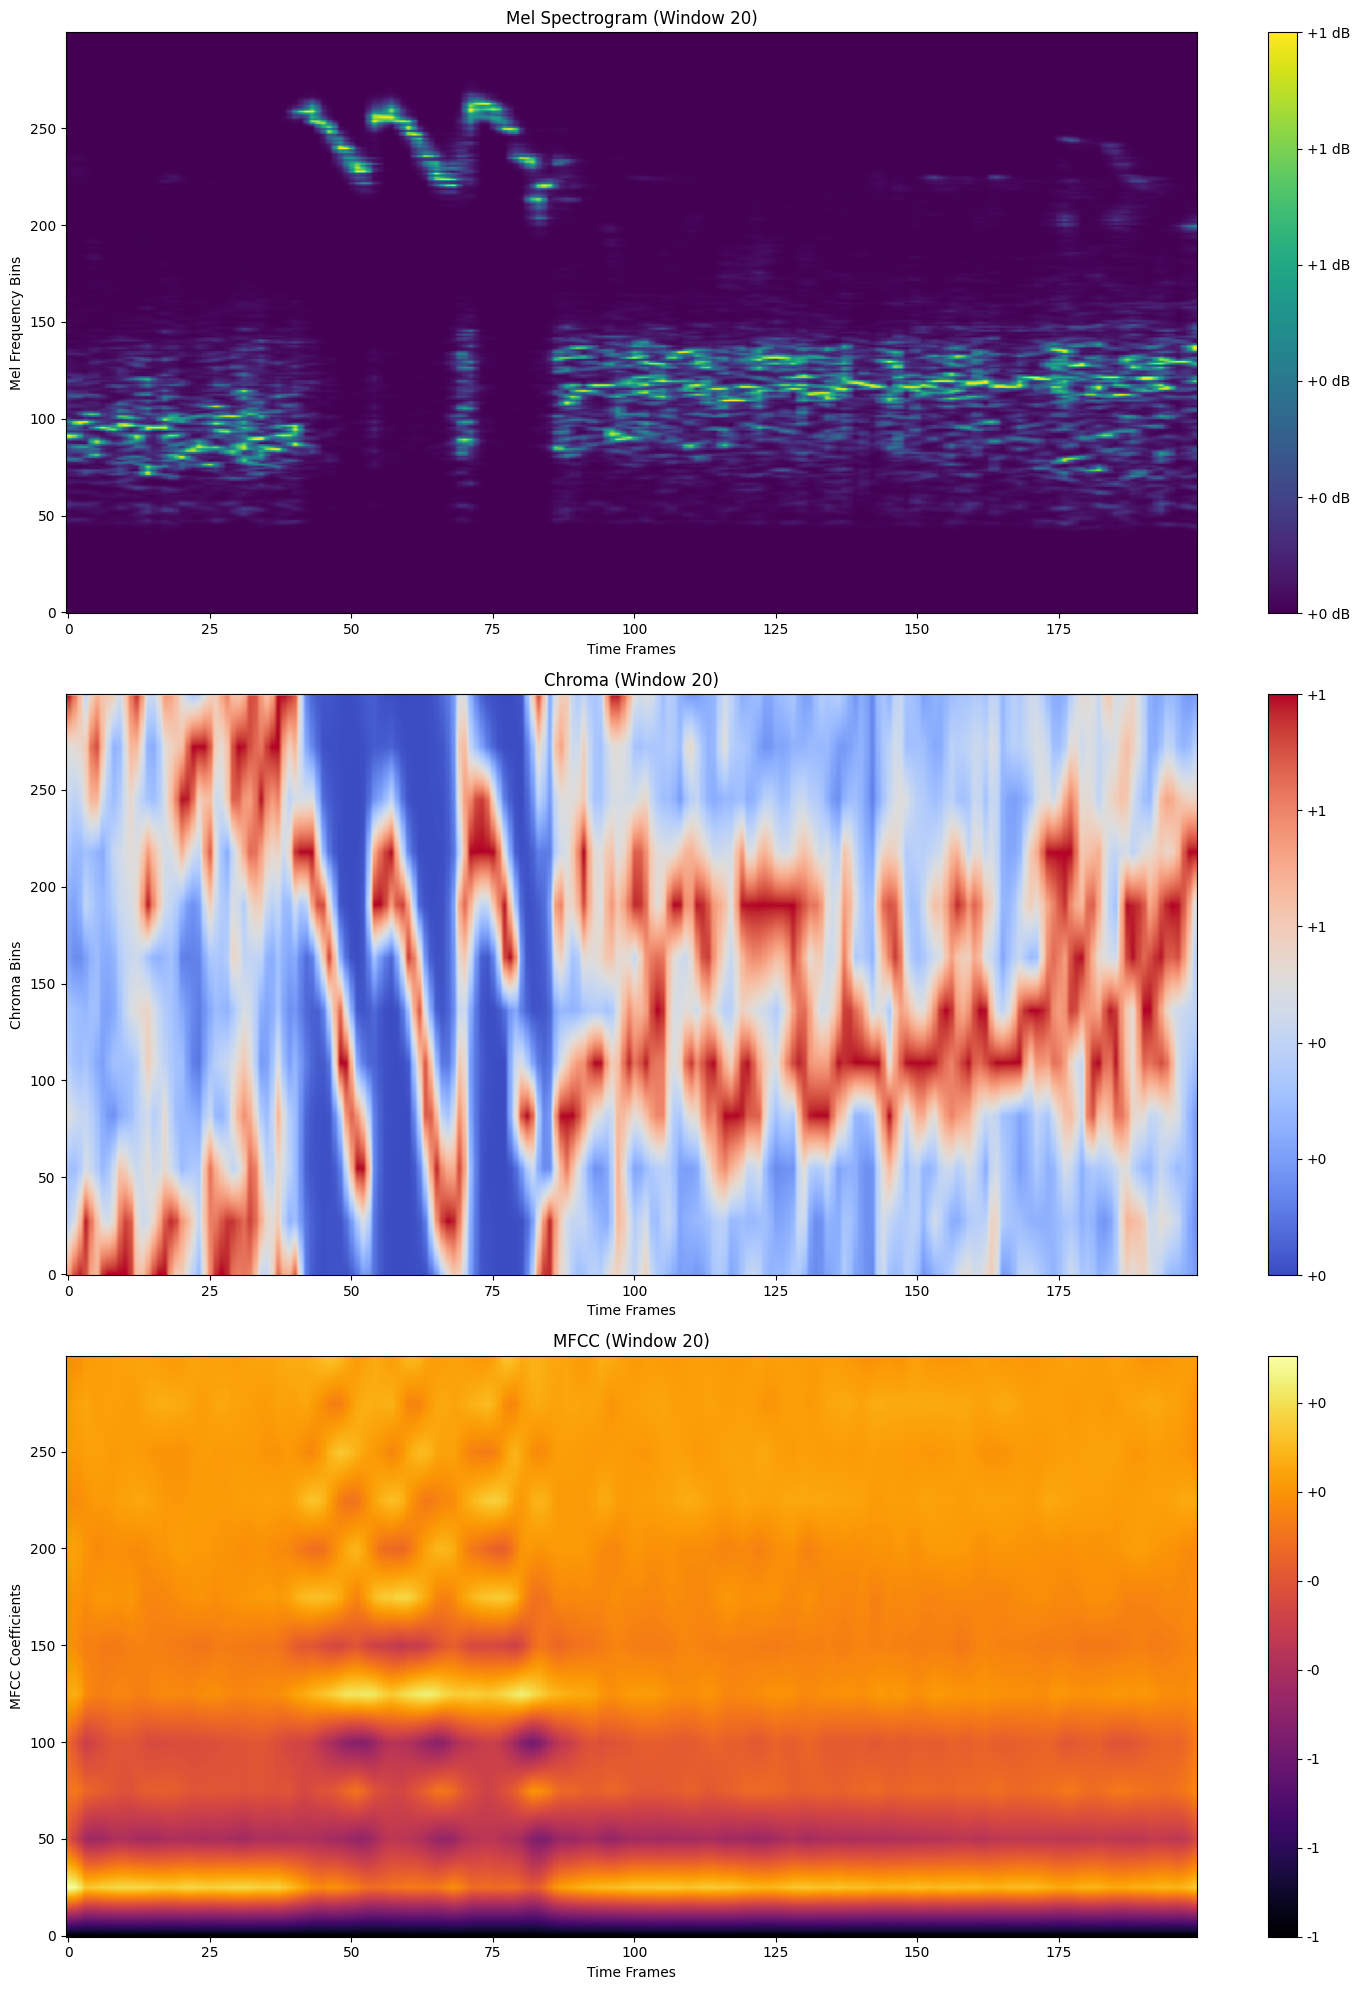

In [58]:
file_path = 'Motacilla flava/XC252756.npy'
label = 'Motacilla flava'

example_path = npy_path + file_path

spectrogram_data = check_process_audio_file(example_path, label, window_size=3, overlap=0.5)

window_index_to_plot = 20
audio_widget = plot_spectrogram(spectrogram_data, window_index_to_plot, window_size=3, file_path=example_path)
display(audio_widget)

# **Processing the training data**

In [62]:
processed_train_data = process_dataset(
    train_data,
    window_size=4,
    overlap=0.5,
    target_shape=(300, 200),
    normalize=True,
    average_pooling=False,
    save_path=save_path
)

Processing data: 483it [08:28,  1.05s/it]
C:\Users\thato\AppData\Local\Temp\ipykernel_19012\3271826754.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_spectrograms'] = processed_data


In [63]:
processed_train_data.head()

,Unnamed: 0,species,audio_name,duration,filename_npy,set,processed_spectrograms
0,542,Fulica atra,XC504105.mp3,74.202041,Fulica atra/XC504105.npy,tr,{'features': [[[[ 3.45461357e-03 2.81875355e-...
1,562,Fulica atra,XC548458.mp3,11.853787,Fulica atra/XC548458.npy,tr,{'features': [[[[ 2.01279696e-03 7.86764336e-...
2,550,Fulica atra,XC538144.mp3,10.381678,Fulica atra/XC538144.npy,tr,{'features': [[[[ 1.32586967e-01 7.20314414e-...
3,563,Fulica atra,XC548770.mp3,35.738005,Fulica atra/XC548770.npy,tr,{'features': [[[[ 7.34869327e-04 2.62249643e-...
4,559,Fulica atra,XC543771.mp3,3.059002,Fulica atra/XC543771.npy,tr,{'features': [[[[ 5.51799884e-03 2.52135763e-...


In [64]:
train_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/4s-2D-MS-train.pkl'
with open(train_pkl_path, 'wb') as f:
    pickle.dump(processed_train_data, f)

In [65]:
del f

## Processing the validation data

In [66]:
processed_val_data = process_dataset(
    val_data,
    window_size=4,
    overlap=0.5,
    target_shape=(300, 200),
    normalize=True,
    average_pooling=False,
    save_path=save_path
)

Processing data: 132it [01:46,  1.23it/s]
C:\Users\thato\AppData\Local\Temp\ipykernel_19012\3271826754.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_spectrograms'] = processed_data


In [67]:
val_pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V3/feature-extraction/stage-2-1/4s-2D-MS-val.pkl'
with open(val_pkl_path, 'wb') as f:
    pickle.dump(processed_val_data, f)

In [68]:
del f

# Confirming that the pickle files were saved correctly:

In [56]:
with open(train_pkl_path, 'rb') as f:
    train_mel_spectrograms = pickle.load(f)

In [58]:
with open(val_pkl_path, 'rb') as f:
    val_mel_spectrograms = pickle.load(f)

In [59]:
print(f"Training data shape: {train_mel_spectrograms.shape}")
print(f"Validation data shape: {val_mel_spectrograms.shape}")

Training data shape: (483, 7)
Validation data shape: (132, 7)


In [102]:
processed_train_data.head()

,Unnamed: 0,species,audio_name,duration,filename_npy,set,processed_spectrograms
0,542,Fulica atra,XC504105.mp3,74.202041,Fulica atra/XC504105.npy,tr,"{'spectrograms': [[0.049583178, 0.045895133, 0..."
1,562,Fulica atra,XC548458.mp3,11.853787,Fulica atra/XC548458.npy,tr,"{'spectrograms': [[0.09428047, 0.10822497, 0.1..."
2,550,Fulica atra,XC538144.mp3,10.381678,Fulica atra/XC538144.npy,tr,"{'spectrograms': [[0.0057953526, 0.004082481, ..."
3,563,Fulica atra,XC548770.mp3,35.738005,Fulica atra/XC548770.npy,tr,"{'spectrograms': [[0.021571826, 0.024690595, 0..."
4,559,Fulica atra,XC543771.mp3,3.059002,Fulica atra/XC543771.npy,tr,"{'spectrograms': [[0.031731542, 0.041778415, 0..."
